In [1]:
import folium
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import pickle
import random
import gams_magic

In [2]:
# read link data
road_file_path = os.path.join('..','road_file.csv')
road_file = pd.read_csv(road_file_path,names=["RDWY_LINK_ID","REF_SITE_FROM_ID","REF_SITE_TO_ID"])

# read road shape (shape file already converted using CRS in qgis)
shape_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Middleton_Road_New.shp")
shape = shapefile.Reader(shape_path)

# read crash shape
crash_path = os.path.join("..","transportation_data","Middleton_Cross_Plains","Features","Crash_data_combined_2017_2020.shp")
crash = shapefile.Reader(crash_path)

# load reference point coordinate
reference_coordinate = None
reference_path = os.path.join("..","reference_coordinate")

with open(reference_path, 'rb') as f:
    reference_coordinate = pickle.load(f)

# Start Model

In [154]:
%reload_ext gams_magic
%gams_cleanup -k
%gams_reset

In [155]:
%%gams

$title turning network

option limcol = 0, limrow = 0, solprint = off;
set
    nodes
    roadID
    season
    seriousness
;

alias (nodes,i,j);
$gdxin ../turning_network_time_updated.gdx
$loadm nodes=dim1 nodes=dim2
parameter real_distance(nodes,nodes) distance of a road;
$load  real_distance=time
$gdxin


$gdxin ../turning_network_turn_updated.gdx
parameter turn(nodes,nodes) distance of a road;
$load  turn=turn
$gdxin

$gdxin ../crash_drisk0320.gdx
parameter risk(nodes,nodes) distance of a road;
$load  risk=drisk
$gdxin

$gdxin ../crash_count0320.gdx
parameter count(nodes,nodes) distance of a road;
$load  count=count
$gdxin

*display distance;


$gdxin ../turning_network_linkID_updated.gdx
set road(roadID<,i,j);
$load  road=road
$gdxin



$ontext
$gdxin ../crash_file.gdx
parameter  crash(nodes,nodes) number of crashes on a road;
$load  crash=crash
$gdxin
$offtext

$ontext
$gdxin ../crash_seriousness.gdx
$load season=dim3 seriousness=dim4
parameter crashS(nodes,nodes,season,seriousness) number of crashes on a road with different seasons and seriousness;
$load  crashS=serious_crash
$gdxin
$offtext

parameter distance(nodes,nodes);

distance(i,j) = real_distance(i,j);

real_distance(i,j) = real_distance(i,j) + turn(i,j) - 1;

set arc(nodes,nodes);

arc(i,j) = no;
arc(i,j)$(distance(i,j) > 0.5) = yes;
* adjust the distance
distance(i,j)$(arc(i,j)) = distance(i,j) -1;

scalar
    turn_const /100/
    intermediate_val /10/
    Lambda /0.1/;
;

parameter
    supply(nodes)
;

scalar origin,destination;
execseed = 1 + gmillisec(jnow);
origin = uniformint(1,card(nodes));
destination = uniformint(1,card(nodes));

*supply(nodes)$(ord(nodes) = origin) = 1;

*supply(nodes)$(ord(nodes) = destination) = -1;

*supply('1666494_2') = 1;
*supply('1662728_3') = -1;

*supply('1662751_1')=  -1.0;
*supply('1667830_1')=  1.0;




supply('1662117_1') = 1;
supply('1661950_1') = -1;

free variable
    total_dist
;

integer variable
    flow(i,j)
;

flow.lo(i,j) = 0

equation
    balance(nodes)
    objective_shortestPath
    objective_safestPath
    objective_shortestPath2
    objective_short "shortest path formulation"
    intermediate_constr
    turn_constr
;


balance(i)..
    sum(arc(i,j), flow(i,j)) - sum(arc(j,i), flow(j,i)) =e= supply(i);
    
objective_short..
    total_dist =e= sum(arc(i,j),flow(i,j)*distance(i,j));
**********************************************************

intermediate_constr..
    sum(arc(i,j),flow(i,j)*risk(i,j)) =l= intermediate_val;
********************************************************** 

objective_shortestPath..
    total_dist =e= sum(arc(i,j),flow(i,j)*turn(i,j));

objective_shortestPath2..
    total_dist =e= sum(arc(i,j),Lambda*flow(i,j)*distance(i,j) + (1-Lambda)*flow(i,j)*risk(i,j));
    


    
turn_constr..
    sum(arc(i,j),flow(i,j)*turn(i,j)) =l= turn_const;


model seasonalPath /balance, objective_shortestPath/;

model seasonalPath2 /balance, objective_shortestPath2, turn_constr/;

model shortest /balance, objective_short/;

model intermediate /balance, objective_short, intermediate_constr/;

model weighted /balance, objective_shortestPath2/;


***risk model

distance(i,j) = risk(i,j);

solve shortest using mip minimizing total_dist;

set roadChosenRisk(roadID);

scalar 
    roadChosenRisk_risk
;

roadChosenRisk(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenRisk(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

roadChosenRisk_risk = sum(arc(i,j),flow.l(i,j)*risk(i,j));

***crash count model
distance(i,j) = count(i,j);

solve shortest using mip minimizing total_dist;

set roadChosenCount(roadID);

roadChosenCount(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenCount(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

*** pure distance model
distance(i,j) = real_distance(i,j);

solve shortest using mip minimizing total_dist;

set roadChosenDistance(roadID);

scalar 
    roadChosenDistance_risk
;

roadChosenDistance(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenDistance(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

roadChosenDistance_risk = sum(arc(i,j),flow.l(i,j)*risk(i,j));
*** turn model

distance(i,j) = turn(i,j);

solve shortest using mip minimizing total_dist;

set roadChosenTurn(roadID);

roadChosenTurn(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenTurn(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;

*solve seasonalPath2 using mip minimizing total_dist;

*** intermediate model

distance(i,j) = real_distance(i,j);

intermediate_val = (0.2*roadChosenDistance_risk+1.8*roadChosenRisk_risk)/2;

solve intermediate using mip minimizing total_dist;

set roadChosenIntermediate(roadID);

roadChosenIntermediate(roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
roadChosenIntermediate(roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;



*** loop intermediate model


set loopN/ l1*l19/;

set roadChosenIntermediateLoop(loopN,roadID);
parameter roadChosenIntermediateObj(loopN);


loop( loopN,
    Lambda = 0.05 * ord(loopN);
    solve weighted using mip minimizing total_dist;
    
    roadChosenIntermediateLoop(loopN,roadID)$( sum(road(roadID,i,j), flow.l(i,j)) > 0.5) = yes;
    roadChosenIntermediateLoop(loopN,roadID)$( sum(road(roadID,i,j), flow.l(j,i)) > 0.5) = yes;
    roadChosenIntermediateObj(loopN) = weighted.objVal;
);


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Optimal Global (1),446.3334,3211,9043,MIP,CPLEX,0.13
1,Normal (1),Optimal Global (1),0.0000,3211,9043,MIP,CPLEX,0.104
2,Normal (1),Optimal Global (1),254.8889,3211,9043,MIP,CPLEX,0.119
3,Normal (1),Optimal Global (1),5.0000,3211,9043,MIP,CPLEX,0.103
4,Normal (1),Optimal Global (1),268.2227,3212,9043,MIP,CPLEX,0.301
5,Normal (1),Optimal Global (1),437.4941,3211,9043,MIP,CPLEX,0.119
6,Normal (1),Optimal Global (1),428.5851,3211,9043,MIP,CPLEX,0.111
7,Normal (1),Optimal Global (1),419.6761,3211,9043,MIP,CPLEX,0.122
8,Normal (1),Optimal Global (1),410.7671,3211,9043,MIP,CPLEX,0.113
9,Normal (1),Optimal Global (1),401.8580,3211,9043,MIP,CPLEX,0.117


In [156]:
'''
%gams_pull -d flow
%gams_pull supply
%gams_pull -d road
%gams_pull roadChosen
%gams_pull roadChosen2
%gams_pull roadChosen3
%gams_pull roadChosen_time
%gams_pull roadChosen_turn
%gams_pull roadChosen2_time
%gams_pull roadChosen2_turn
%gams_pull roadChosen3_time
%gams_pull roadChosen3_turn
'''

'\n%gams_pull -d flow\n%gams_pull supply\n%gams_pull -d road\n%gams_pull roadChosen\n%gams_pull roadChosen2\n%gams_pull roadChosen3\n%gams_pull roadChosen_time\n%gams_pull roadChosen_turn\n%gams_pull roadChosen2_time\n%gams_pull roadChosen2_turn\n%gams_pull roadChosen3_time\n%gams_pull roadChosen3_turn\n'

In [157]:
%gams_pull -d flow
%gams_pull supply
%gams_pull -d road
%gams_pull roadChosenRisk
%gams_pull roadChosenCount
%gams_pull roadChosenDistance
%gams_pull roadChosenTurn
%gams_pull roadChosenIntermediate
%gams_pull -d roadChosenIntermediateLoop
%gams_pull roadChosenIntermediateObj
%gams_pull roadChosenDistance_risk
%gams_pull roadChosenRisk_risk

In [158]:
roadChosenDistance_risk

[564.4840508307803]

In [159]:
roadChosenRisk_risk

[446.333355832722]

In [160]:
roadChosenIntermediateObj

[('l1', 437.49412021185043),
 ('l2', 428.58510043337844),
 ('l3', 419.6760806549063),
 ('l4', 410.76706087643424),
 ('l5', 401.85804109796214),
 ('l6', 392.94902131949004),
 ('l7', 384.0400015410179),
 ('l8', 375.13098176254584),
 ('l9', 366.22196198407374),
 ('l10', 357.31294220560164),
 ('l11', 348.4039224271296),
 ('l12', 339.49490264865744),
 ('l13', 330.5858828701854),
 ('l14', 321.6768630917133),
 ('l15', 312.7678433132412),
 ('l16', 303.338785120234),
 ('l17', 292.1201725378644),
 ('l18', 280.90155995549486),
 ('l19', 269.6829473731253)]

In [161]:
roadChosenIntermediateLoop

,loopN,roadID
0,l1,intersection_292
1,l1,intersection_296
2,l1,intersection_401
3,l1,intersection_410
4,l1,intersection_472
...,...,...
1757,l19,4829564
1758,l19,4829565
1759,l19,4850949
1760,l19,intersection_5429


In [162]:
loopChosenRoad = []
for loop in set(roadChosenIntermediateLoop["loopN"]):
    df = roadChosenIntermediateLoop[roadChosenIntermediateLoop["loopN"]==loop]
    links = list(df["roadID"])
    tempChosenRoad = []
    for link in links:
        if "intersection" not in link:
            tempChosenRoad.append(int(link)) 
    loopChosenRoad.append(tempChosenRoad)
    
    
chosen_loop = []
for loop in range(0,19):
    temp_chosen_loop = []
    links = loopChosenRoad[loop]
    for sp in shape.shapeRecords():
        road_id = sp.record[43]

        x = [i[0] for i in sp.shape.points[:]]
        y = [i[1] for i in sp.shape.points[:]]

        #record chosen road
        if road_id in links:
            segment = []
            for i in range(len(x)):
                    segment.append((y[i],x[i]))
            temp_chosen_loop.append(segment)
    chosen_loop.append(temp_chosen_loop)

In [163]:
# get the chosen road
chosen_road_risk = []
chosen_road_count = []
chosen_road_distance = []
chosen_road_turn = []
chosen_road_intermediate = []
for link in roadChosenRisk:
    if "intersection" not in link:
        chosen_road_risk.append(int(link)) 
        
for link in roadChosenCount:
    if "intersection" not in link:
        chosen_road_count.append(int(link))
                                 
for link in roadChosenDistance:
    if "intersection" not in link:
        chosen_road_distance.append(int(link))
        
for link in roadChosenTurn:
    if "intersection" not in link:
        chosen_road_turn.append(int(link))
        
for link in roadChosenIntermediate:
    if "intersection" not in link:
        chosen_road_intermediate.append(int(link))
        
# get the chosen origin and destination
origin = None
destination = None
for i in supply:
    if i[1] == 1:
        origin = int(i[0].split("_")[0])
    else:
        destination = int(i[0].split("_")[0]) 

In [164]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()

    
chosen_risk = []
chosen_count = []
chosen_distance = []
chosen_turn = []
chosen_intermediate = []
#plot original map 
for sp in shape.shapeRecords():
    road_id = sp.record[43]

    x = [i[0] for i in sp.shape.points[:]]
    y = [i[1] for i in sp.shape.points[:]]
        
    #record chosen road
    if road_id in chosen_road_risk:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_risk.append(segment)
    
    if road_id in chosen_road_count:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_count.append(segment)
        
    if road_id in chosen_road_distance:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_distance.append(segment)
        
    if road_id in chosen_road_turn:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_turn.append(segment)
        
    if road_id in chosen_road_intermediate:
        segment = []
        for i in range(len(x)):
                segment.append((y[i],x[i]))
        chosen_intermediate.append(segment)
        

<Figure size 1440x720 with 0 Axes>

In [165]:
m = folium.Map(location=[43.0819, -89.5579])

for loc in chosen_risk:
    folium.PolyLine(loc,
                color='red',
                weight=7,
                opacity=0.8).add_to(m)
'''   
for loc in chosen_count:
    folium.PolyLine(loc,
                color='blue',
                weight=5,
                opacity=0.8).add_to(m)
'''

for loc in chosen_distance:
    folium.PolyLine(loc,
                color='green',
                weight=6,
                opacity=0.8).add_to(m)
'''   
for loc in chosen_turn:
    folium.PolyLine(loc,
                color='orange',
                weight=3,
                opacity=0.8).add_to(m)
'''
'''
for loc in chosen_intermediate:
    folium.PolyLine(loc,
                color='purple',
                weight=4,
                opacity=0.8).add_to(m)
'''
'''
for i in range(0,9):
    for loc in chosen_loop[i]:
        folium.PolyLine(loc,
            color='blue',
            weight=1,
            opacity=0.1).add_to(m)
'''
'''
last = -1
colors = ["blue","purple"]
colorIndex = 0

for i in range(0,19):
    #if roadChosenIntermediateObj[i][1] != last:
    #    print(i)
    #    last = roadChosenIntermediateObj[i][1]
    for loc in chosen_loop[i]:
        if i > 17:
            folium.PolyLine(loc,
                color="yellow",
                weight=4,
                opacity=1).add_to(m)
        else:
            folium.PolyLine(loc,
                color="purple",
                weight=2,
                opacity=1).add_to(m)
    #colorIndex +=1

'''

'\nlast = -1\ncolors = ["blue","purple"]\ncolorIndex = 0\n\nfor i in range(0,19):\n    #if roadChosenIntermediateObj[i][1] != last:\n    #    print(i)\n    #    last = roadChosenIntermediateObj[i][1]\n    for loc in chosen_loop[i]:\n        if i > 17:\n            folium.PolyLine(loc,\n                color="yellow",\n                weight=4,\n                opacity=1).add_to(m)\n        else:\n            folium.PolyLine(loc,\n                color="purple",\n                weight=2,\n                opacity=1).add_to(m)\n    #colorIndex +=1\n\n'

In [166]:
m

In [371]:
last = 0
colors = ["orange","yellow","blue","purble","black"]
colorIndex = 0

for i in range(0,9):
    if roadChosenIntermediateObj[i][1] != last:
        last = roadChosenIntermediateObj[i][1]
        for loc in chosen_loop[i]:
            folium.PolyLine(loc,
                color=colors[colorIndex],
                weight=3,
                opacity=1).add_to(m)
        colorIndex += 1

AttributeError: module 'matplotlib.pyplot' has no attribute 'vline'

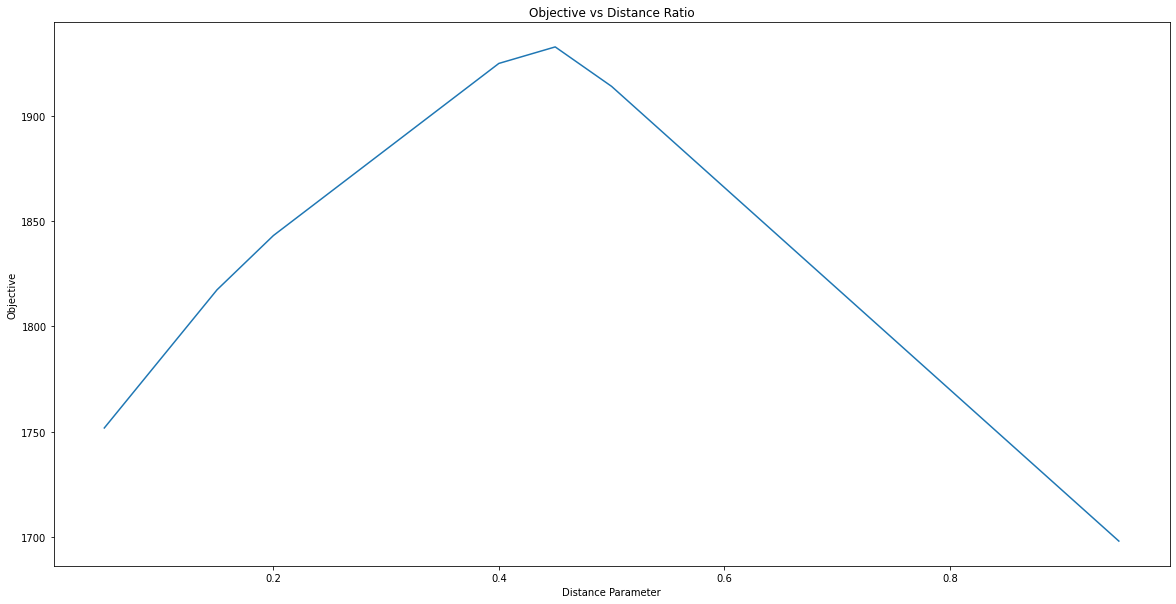

In [61]:
objList = []
distanceWeight = []
for i in range(0,19):
    objList.append(roadChosenIntermediateObj[i][1])
    distanceWeight.append((i+1)*0.05) 
plt.plot(distanceWeight, objList)
plt.title('Objective vs Distance Ratio')
plt.xlabel('Distance Parameter')
plt.ylabel('Objective')
plt.vlines(0.17)
plt.show()

In [ ]:
m = folium.Map(location=[43.0819, -89.5579])
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_counters['Name'][point]).add_to(map)

In [88]:
reference_coordinate

{1662183: [548146.3613, 293559.28800000064],
 1662181: [548052.6239999998, 293572.75100000016],
 1662178: [547850.915, 293574.8239999991],
 1663717: [558256.0949999997, 291242.9079999998],
 1662307: [548766.2000000002, 293332.8650000002],
 1662280: [548682.8839999996, 293382.1129999999],
 1662225: [548497.9610000001, 293485.9000000004],
 1662201: [548340.1255999999, 293529.1440999992],
 10492: [546827.3090000004, 293767.82100000046],
 2176406: [559185.2019999996, 291755.5820000004],
 1663265: [551429.6409999998, 291764.9690000005],
 2216703: [548871.9989999998, 293244.45900000073],
 1662192: [548244.0439999998, 293544.3379999995],
 2180701: [559524.6900000004, 294744.2569999993],
 15381: [559540.7750000004, 291677.6490000002],
 1662353: [548815.5240000002, 293291.2139999997],
 1662251: [548614.5800000001, 293420.33400000073],
 1662209: [548441.8629999999, 293512.8929999992],
 1663569: [552114.9709999999, 291326.6040000003],
 1662179: [547952.6109999996, 293574.46499999985],
 1666699: [

In [150]:
index = 1662117
reference_coordinate[index]

toSort = []
for i in reference_coordinate:
    dist = abs(reference_coordinate[index][0]-reference_coordinate[i][0]) + \
            abs(reference_coordinate[index][1]-reference_coordinate[i][1])
    
    toSort.append((i,dist))

In [151]:
reference_coordinate[1666699]

[549858.0899999999, 287309.2109999992]

In [152]:
def dist(element):
    return element[1]

In [153]:
sorted(toSort,key = dist)

[(1662117, 0.0),
 (1662119, 100.24700000043958),
 (1662118, 100.46700000111014),
 (1662179, 101.82000000122935),
 (1662057, 107.49899999983609),
 (1662181, 201.82500000018626),
 (1662178, 203.15700000151992),
 (1662129, 210.90000000037253),
 (1662054, 215.21599999908358),
 (1662120, 224.17399999964982),
 (1662206, 253.36900000087917),
 (1662079, 263.16899999883026),
 (1662177, 302.27500000130385),
 (1662121, 302.55800000112504),
 (1662183, 309.0252999998629),
 (1662138, 325.42899999953806),
 (1662039, 333.339999999851),
 (1662065, 384.2739999992773),
 (10503, 385.02600000146776),
 (1662083, 400.93099999893457),
 (1661897, 409.39699999894947),
 (1662192, 421.6580000007525),
 (1662149, 437.42700000014156),
 (1662070, 462.80599999893457),
 (1662320, 477.7139999996871),
 (2052314, 496.3420000001788),
 (1662019, 511.7739999992773),
 (1662201, 532.933500001207),
 (1662075, 542.9609999991953),
 (1662154, 551.7680000010878),
 (1662023, 555.1490000002086),
 (1662351, 568.9550000000745),
 (20523